## Preparation

##### Import Functions

In [1]:
from Scripts.LoadImage import LoadImage as LoadImage
from Scripts.Fuzzify import Fuzzify as Fuzzify
from Class.Helper import Helper as Helper
from Scripts.Ki67 import Ki67 as Ki67

In [3]:
import numpy as np
import pandas as pd
from os import listdir
from skimage import io
from skimage.draw import circle, circle_perimeter
from matplotlib import pyplot as plt
from skimage.color import rgb2hsv, rgb2hed, hed2rgb, rgb2gray

##### Functions

In [4]:
def getRecall(markers, mask):
    radius = 3
    hits = markers.apply(lambda marker: mask[int(marker['y'])-radius:int(marker['y']) + radius + 1, int(marker['x'])-radius:int(marker['x']) + radius + 1].any(),axis=1)
    recall = hits.sum() / len(hits)
    return recall

def validateResults(folder_name, low_x, high_x, low_y, high_y, show_images = False):
    path = settings.data_folder_veryfication
    mask = pickle.load(open(settings.backup_folder + "Images/" + "Test_" + folder_name + "_" + settings.class_1 + "_df_results"  + ".p", "rb"))
    mask = mask.sort_index()
    
    if settings.class_1 == "brown":
        searched_class = 1
    else:
        searched_class = 2
    
    mask = np.reshape(np.array(mask["Decision Fuzzy"]), (-1, high_x - low_x))
    
    mask = [np.ones(3) if j == settings.class_1 else np.zeros(3) for row in mask for j in row]
    mask = np.array(mask)
    mask = mask.reshape((-1, high_x - low_x, 3))

    from skimage.morphology import binary_closing
    from skimage.morphology import disk, remove_small_objects
    from skimage.color import rgb2gray
    from skimage import data, io, segmentation, color

    file_path = path + folder_name
    image_raw= io.imread(file_path + "/fragment.png")
    base = io.imread(file_path + "/base.png")
    markers = pd.read_csv(file_path + "/markers.csv")

#     k = 1000 / base.shape[1]
    k = 3
    markers.loc[:, 'x'] = markers.x.apply(lambda x: np.ceil(x / k))
    markers.loc[:, 'y'] = markers.y.apply(lambda y: np.ceil(y / k))
    markers = markers.drop(markers[((markers.x < low_x) | (markers.x > high_x)) | ((markers.y < low_y) | (markers.y > high_y))].index)
    markers.loc[:, 'x'] = markers.x.apply(lambda x: x - low_x)
    markers.loc[:, 'y'] = markers.y.apply(lambda y: y - low_y)

    markers = markers.loc[markers.type == searched_class]

    if show_images:
        fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(70, 45))
    mask_gray = rgb2gray(mask)
    if show_images:
        ax[0].imshow(mask, cmap=plt.cm.gray)
    mask_gray = binary_closing(mask_gray, disk(1))
    if show_images:
        ax[1].imshow(mask_gray, cmap=plt.cm.gray)
    mask_gray = remove_small_objects(mask_gray, 3)
    if show_images:
        ax[2].imshow(mask_gray, cmap=plt.cm.gray)
    mask_gray = binary_closing(mask_gray, disk(2))
    if show_images:
        ax[3].imshow(mask_gray, cmap=plt.cm.gray)

    mask_gray = mask_gray.astype(bool)
    recall = getRecall(markers, mask_gray)
    
    if show_images:
        for center_y, center_x in zip(markers.y, markers.x):
            circy, circx = circle_perimeter(int(center_y), int(center_x), 0)
            image_raw[circy, circx] = (220, 20, 20)
        
        ax[4].imshow(image_raw, cmap=plt.cm.gray)
        plt.show()
        
    return recall

##### Import Settings

In [363]:
from Settings.SettingsKi67 import Settings as Settings
import Settings.GeneralSettings as generalSettings
settings = Settings(generalSettings)

##### Load Image

In [364]:
loadImage = LoadImage()
samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = False)

../Data/Ki67-Train/backgoround.png
../Data/Ki67-Train/blue.png
../Data/Ki67-Train/brown.png


### Train mode

In [262]:
fuzzify = Fuzzify()
changed_decisions, features_number_after_reduct, implicants_number, fuzzify_parameters, execution_time = fuzzify.worker(settings, -1)

In [7]:
from Settings.SettingsKi67 import Settings as Settings
import Settings.GeneralSettings as generalSettings

for gauss in [3, 5]:
    for style in ["Gaussian Equal"]: #  for style in ["Gaussian Progressive", "Gaussian Equal"]:
        for adjustment in [-1]:      #  for adjustment in [-1, -2]:
            for cell_type in ["brown", "blue"]:
                generalSettings.gausses = gauss
                generalSettings.style = style
                generalSettings.adjustment_value = adjustment
                generalSettings.class_1 = cell_type
                settings = Settings(generalSettings)        

                # Generate Rules
                loadImage = LoadImage()
                samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = False)

                fuzzify = Fuzzify()
                changed_decisions, features_number_after_reduct, implicants_number, fuzzify_parameters, execution_time = fuzzify.worker(settings, -1)

                # Validate Results
                for file_name in ["1628-05", "18583-04", "31374-10",]:
                    generalSettings.file_name = file_name
                    settings = Settings(generalSettings)     
                    loadImage = LoadImage()
                    samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = -1)

                    ki67Test = Ki67(settings, settings.s_function_width, False)
                    ki67Test.noOptymalizationWorker(settings)

                    if file_name == "1628-05":
                        recall_1 = validateResults(settings.file_name, 85, 449, 172, 533, False)
                    elif file_name == "18583-04":
                        recall_2 = validateResults(settings.file_name, 1732, 2011, 583, 995, False)
                    else:
                        recall_3 = validateResults(settings.file_name, 432, 794, 300, 566, False)
                avg_recall = (recall_1 + recall_2 + recall_3) / 3
                helper = Helper()

                fuzzification_data = ["Ki67", settings.style, settings.gausses, settings.adjustment, settings.class_1, settings.features_type, samples_stats, train_stats, test_stats, changed_decisions, round(changed_decisions / train_samples, 2), implicants_number, settings.feature_numbers, features_number_after_reduct, recall_1, recall_2, recall_3, avg_recall, execution_time]
                helper.saveFuzzificationStatsKi67(fuzzification_data)

../Data/Ki67-Train/backgoround.png
../Data/Ki67-Train/blue.png
../Data/Ki67-Train/brown.png
../Data/Ki67-Veryfication/1628-05/fragment.png


100%|█████████████████████████████████████████████████████████████████████████| 131404/131404 [05:07<00:00, 427.75it/s]


-----------------------------------------------------------------------------------
Time: 322.0876052379608
-----------------------------------------------------------------------------------
../Data/Ki67-Veryfication/18583-04/fragment.png


100%|█████████████████████████████████████████████████████████████████████████| 114948/114948 [05:27<00:00, 351.40it/s]


-----------------------------------------------------------------------------------
Time: 342.878342628479
-----------------------------------------------------------------------------------
../Data/Ki67-Veryfication/31374-10/fragment.png


100%|███████████████████████████████████████████████████████████████████████████| 96292/96292 [05:48<00:00, 276.44it/s]


-----------------------------------------------------------------------------------
Time: 361.9341621398926
-----------------------------------------------------------------------------------


,Dataset,Style,Gausses,Adjustment,Searched Class,Features type,Samples,Train s.,Test s.,Changed s.,% changed s.,Implicants,Features,F. after reduct,Recall 1,Recall 2,Recall 3,Average Recall,Execution Time
0,Ki67,Gaussian Equal,3,Mean,brown,1,96292 (--/--),-- (--/--),96292 (--/--),3,0.0,27,5,5,0.777778,0.9,0.875,0.850926,8.093467


../Data/Ki67-Train/backgoround.png
../Data/Ki67-Train/blue.png
../Data/Ki67-Train/brown.png
../Data/Ki67-Veryfication/1628-05/fragment.png


100%|█████████████████████████████████████████████████████████████████████████| 131404/131404 [06:25<00:00, 340.47it/s]


-----------------------------------------------------------------------------------
Time: 405.03297996520996
-----------------------------------------------------------------------------------
../Data/Ki67-Veryfication/18583-04/fragment.png


100%|█████████████████████████████████████████████████████████████████████████| 114948/114948 [06:30<00:00, 294.39it/s]


-----------------------------------------------------------------------------------
Time: 407.41539311408997
-----------------------------------------------------------------------------------
../Data/Ki67-Veryfication/31374-10/fragment.png


100%|███████████████████████████████████████████████████████████████████████████| 96292/96292 [06:20<00:00, 252.96it/s]


-----------------------------------------------------------------------------------
Time: 396.398432970047
-----------------------------------------------------------------------------------


,Dataset,Style,Gausses,Adjustment,Searched Class,Features type,Samples,Train s.,Test s.,Changed s.,% changed s.,Implicants,Features,F. after reduct,Recall 1,Recall 2,Recall 3,Average Recall,Execution Time
0,Ki67,Gaussian Equal,3,Mean,blue,1,96292 (--/--),-- (--/--),96292 (--/--),5,0.0,27,5,5,0.824242,0.82963,0.430108,0.694660,9.292650
1,Ki67,Gaussian Equal,3,Mean,brown,1,96292 (--/--),-- (--/--),96292 (--/--),3,0.0,27,5,5,0.777778,0.90000,0.875000,0.850926,8.093467


../Data/Ki67-Train/backgoround.png
../Data/Ki67-Train/blue.png
../Data/Ki67-Train/brown.png
../Data/Ki67-Veryfication/1628-05/fragment.png


100%|█████████████████████████████████████████████████████████████████████████| 131404/131404 [08:47<00:00, 249.31it/s]


-----------------------------------------------------------------------------------
Time: 561.1553170681
-----------------------------------------------------------------------------------
../Data/Ki67-Veryfication/18583-04/fragment.png


100%|█████████████████████████████████████████████████████████████████████████| 114948/114948 [10:04<00:00, 190.08it/s]


-----------------------------------------------------------------------------------
Time: 621.6778073310852
-----------------------------------------------------------------------------------
../Data/Ki67-Veryfication/31374-10/fragment.png


100%|███████████████████████████████████████████████████████████████████████████| 96292/96292 [10:14<00:00, 156.76it/s]


-----------------------------------------------------------------------------------
Time: 630.1795198917389
-----------------------------------------------------------------------------------


,Dataset,Style,Gausses,Adjustment,Searched Class,Features type,Samples,Train s.,Test s.,Changed s.,% changed s.,Implicants,Features,F. after reduct,Recall 1,Recall 2,Recall 3,Average Recall,Execution Time
0,Ki67,Gaussian Equal,3,Mean,blue,1,96292 (--/--),-- (--/--),96292 (--/--),5,0.0,27,5,5,0.824242,0.82963,0.430108,0.694660,9.292650
1,Ki67,Gaussian Equal,3,Optymalized,blue,1,96292 (--/--),-- (--/--),96292 (--/--),5,0.0,27,5,5,0.824242,0.82963,0.430108,0.694660,11.349005
2,Ki67,Gaussian Equal,3,Mean,brown,1,96292 (--/--),-- (--/--),96292 (--/--),3,0.0,27,5,5,0.777778,0.90000,0.875000,0.850926,8.093467
3,Ki67,Gaussian Equal,3,Optymalized,brown,1,96292 (--/--),-- (--/--),96292 (--/--),3,0.0,27,5,5,0.777778,0.90000,0.875000,0.850926,8.260009
4,Ki67,Gaussian Equal,5,Mean,brown,1,96292 (--/--),-- (--/--),96292 (--/--),6,0.0,68,5,5,1.000000,1.00000,1.000000,1.000000,54.682008


../Data/Ki67-Train/backgoround.png
../Data/Ki67-Train/blue.png
../Data/Ki67-Train/brown.png
../Data/Ki67-Veryfication/1628-05/fragment.png


 30%|█████████████████████▉                                                    | 38873/131404 [02:44<06:02, 255.19it/s]

KeyboardInterrupt: 

 30%|█████████████████████▉                                                    | 38879/131404 [03:00<06:02, 255.19it/s]

In [16]:
from Settings.SettingsKi67 import Settings as Settings
import Settings.GeneralSettings as generalSettings


for cell_type in ["blue"]:
    generalSettings.gausses = 5
    generalSettings.style = "Gaussian Equal"
    generalSettings.adjustment_value = -1
    generalSettings.class_1 = cell_type
    generalSettings.features_type = 12
    settings = Settings(generalSettings)        

    # Generate Rules
    loadImage = LoadImage()
    samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = False)

    fuzzify = Fuzzify()
    changed_decisions, features_number_after_reduct, implicants_number, fuzzify_parameters, execution_time = fuzzify.worker(settings, -1)

    # Validate Results
    for file_name in ["1628-05", "18583-04", "31374-10",]:
        generalSettings.file_name = file_name
        settings = Settings(generalSettings)     
        loadImage = LoadImage()
        samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = -1)

        ki67Test = Ki67(settings, settings.s_function_width, False)
        ki67Test.noOptymalizationWorker(settings)

        if file_name == "1628-05":
            recall_1 = validateResults(settings.file_name, 85, 449, 172, 533, False)
        elif file_name == "18583-04":
            recall_2 = validateResults(settings.file_name, 1732, 2011, 583, 995, False)
        else:
            recall_3 = validateResults(settings.file_name, 432, 794, 300, 566, False)
    avg_recall = (recall_1 + recall_2 + recall_3) / 3
    helper = Helper()

    fuzzification_data = ["Ki67", settings.style, settings.gausses, settings.adjustment, settings.class_1, settings.features_type, samples_stats, train_stats, test_stats, changed_decisions, round(changed_decisions / train_samples, 2), implicants_number, settings.feature_numbers, features_number_after_reduct, recall_1, recall_2, recall_3, avg_recall, execution_time]
    helper.saveFuzzificationStatsKi67(fuzzification_data)

../Data/Ki67-Train/backgoround.png
../Data/Ki67-Train/blue.png
../Data/Ki67-Train/brown.png
../Data/Ki67-Veryfication/1628-05/fragment.png



  3%|██▌                                                                        | 4461/131404 [00:09<04:13, 501.25it/s]


  7%|████▉                                                                      | 8562/131404 [00:18<05:56, 344.26it/s]


 10%|███████                                                                   | 12622/131404 [00:29<05:58, 331.66it/s]


 13%|█████████▍                                                                | 16737/131404 [00:40<06:19, 302.05it/s]


 16%|███████████▊                                                              | 20887/131404 [00:50<04:11, 439.24it/s]


 19%|██████████████▏                                                           | 25148/131404 [01:00<05:03, 350.34it/s]


 22%|████████████████▍                                                         | 29230/131404 [01:11<04:21, 390.93it/s]


 25%|██████████████████▋                                                       | 33099/131404 [01:21<05:56, 275.75it/s]


 28%|████████████████████▋                                                     | 36644/131404 [01:31<05:39, 279.28it/s]


 31%|██████████████████████▌                                                   | 40134/131404 [01:42<04:44, 320.85it/s]


 33%|████████████████████████▋                                                 | 43785/131404 [01:53<04:23, 332.77it/s]


 36%|██████████████████████████▊                                               | 47645/131404 [02:04<04:50, 287.87it/s]


 39%|████████████████████████████▉                                             | 51427/131404 [02:14<03:37, 367.03it/s]


 42%|███████████████████████████████▏                                          | 55318/131404 [02:25<04:38, 273.63it/s]


 45%|█████████████████████████████████▍                                        | 59298/131404 [02:36<04:06, 293.02it/s]


 48%|███████████████████████████████████▌                                      | 63185/131404 [02:47<02:58, 381.96it/s]


 51%|█████████████████████████████████████▊                                    | 67057/131404 [02:57<03:36, 297.47it/s]


 55%|████████████████████████████████████████▍                                 | 71850/131404 [03:08<03:13, 307.82it/s]


 58%|███████████████████████████████████████████▏                              | 76644/131404 [03:20<02:33, 356.08it/s]


 61%|█████████████████████████████████████████████▏                            | 80337/131404 [03:30<02:50, 299.30it/s]


 63%|██████████████████████████████████████████████▉                           | 83353/131404 [03:40<02:51, 280.06it/s]


 66%|████████████████████████████████████████████████▍                         | 86074/131404 [03:49<02:54, 259.32it/s]


 67%|█████████████████████████████████████████████████▊                        | 88368/131404 [03:59<03:14, 221.55it/s]


 69%|███████████████████████████████████████████████████                       | 90772/131404 [04:07<02:16, 298.52it/s]


 71%|████████████████████████████████████████████████████▌                     | 93236/131404 [04:16<02:17, 277.53it/s]


 73%|█████████████████████████████████████████████████████▊                    | 95607/131404 [04:26<02:36, 228.13it/s]


 75%|███████████████████████████████████████████████████████▏                  | 97976/131404 [04:35<02:04, 268.96it/s]


 76%|███████████████████████████████████████████████████████▊                 | 100417/131404 [04:44<02:31, 204.02it/s]


 78%|█████████████████████████████████████████████████████████▏               | 102979/131404 [04:53<02:06, 224.95it/s]


 80%|██████████████████████████████████████████████████████████▋              | 105616/131404 [05:02<01:23, 307.65it/s]


 82%|████████████████████████████████████████████████████████████             | 108168/131404 [05:11<01:20, 286.99it/s]


 84%|█████████████████████████████████████████████████████████████▍           | 110594/131404 [05:20<01:43, 200.73it/s]


 86%|██████████████████████████████████████████████████████████████▋          | 112775/131404 [05:30<01:42, 182.11it/s]


 88%|███████████████████████████████████████████████████████████████▉         | 115112/131404 [05:40<01:50, 147.16it/s]


 89%|█████████████████████████████████████████████████████████████████▎       | 117492/131404 [05:50<01:07, 205.41it/s]


 91%|██████████████████████████████████████████████████████████████████▋      | 120081/131404 [06:01<00:54, 208.62it/s]


 94%|████████████████████████████████████████████████████████████████████▊    | 123825/131404 [06:11<00:19, 393.48it/s]


 98%|███████████████████████████████████████████████████████████████████████▌ | 128737/131404 [06:21<00:04, 650.47it/s]


100%|█████████████████████████████████████████████████████████████████████████| 131404/131404 [06:28<00:00, 337.85it/s]

-----------------------------------------------------------------------------------
Time: 407.3238351345062
-----------------------------------------------------------------------------------
../Data/Ki67-Veryfication/18583-04/fragment.png



  3%|██▍                                                                        | 3752/114948 [00:11<06:30, 285.07it/s]


  6%|████▍                                                                      | 6814/114948 [00:22<07:27, 241.85it/s]


  9%|██████▍                                                                    | 9793/114948 [00:32<06:05, 288.02it/s]


 11%|████████▍                                                                 | 13041/114948 [00:43<07:54, 214.59it/s]


 15%|██████████▉                                                               | 16987/114948 [00:54<05:19, 306.24it/s]


 18%|█████████████▎                                                            | 20674/114948 [01:05<05:23, 290.97it/s]


 20%|██████████████▊                                                           | 22984/114948 [01:14<06:55, 221.42it/s]


 22%|████████████████                                                          | 24976/114948 [01:23<07:17, 205.84it/s]


 23%|█████████████████▍                                                        | 26996/114948 [01:32<07:28, 195.99it/s]


 25%|██████████████████▋                                                       | 29094/114948 [01:40<06:01, 237.39it/s]


 27%|███████████████████▉                                                      | 31049/114948 [01:49<05:42, 245.29it/s]


 29%|█████████████████████▏                                                    | 32961/114948 [01:57<05:27, 250.10it/s]


 30%|██████████████████████▌                                                   | 35056/114948 [02:06<06:18, 211.07it/s]


 32%|████████████████████████                                                  | 37299/114948 [02:15<06:30, 199.06it/s]


 35%|█████████████████████████▌                                                | 39659/114948 [02:24<04:31, 277.71it/s]


 37%|███████████████████████████▏                                              | 42143/114948 [02:34<04:42, 257.66it/s]


 39%|████████████████████████████▊                                             | 44718/114948 [02:43<04:05, 285.65it/s]


 41%|██████████████████████████████                                            | 46615/114948 [02:52<04:50, 235.55it/s]


 42%|███████████████████████████████▏                                          | 48416/114948 [03:00<05:25, 204.29it/s]


 43%|████████████████████████████████▏                                         | 50000/114948 [03:07<05:25, 199.53it/s]


 45%|█████████████████████████████████                                         | 51383/114948 [03:15<07:24, 143.04it/s]


 46%|█████████████████████████████████▉                                        | 52689/114948 [03:23<05:23, 192.45it/s]


 47%|██████████████████████████████████▊                                       | 54083/114948 [03:30<07:25, 136.48it/s]


 48%|███████████████████████████████████▋                                      | 55381/114948 [03:38<05:12, 190.68it/s]


 49%|████████████████████████████████████▌                                     | 56817/114948 [03:46<05:13, 185.63it/s]


 51%|█████████████████████████████████████▌                                    | 58382/114948 [03:53<04:21, 216.22it/s]


 52%|██████████████████████████████████████▌                                   | 59956/114948 [04:01<04:55, 186.09it/s]


 54%|███████████████████████████████████████▌                                  | 61534/114948 [04:09<04:41, 189.47it/s]


 55%|████████████████████████████████████████▌                                 | 63040/114948 [04:17<04:35, 188.72it/s]


 56%|█████████████████████████████████████████▌                                | 64562/114948 [04:24<04:23, 191.58it/s]


 58%|██████████████████████████████████████████▌                               | 66118/114948 [04:32<04:36, 176.37it/s]


 59%|███████████████████████████████████████████▌                              | 67702/114948 [04:40<03:45, 209.96it/s]


 61%|████████████████████████████████████████████▊                             | 69613/114948 [04:48<02:59, 252.40it/s]


 63%|██████████████████████████████████████████████▎                           | 71917/114948 [04:57<03:12, 223.91it/s]


 65%|███████████████████████████████████████████████▊                          | 74302/114948 [05:07<02:44, 246.37it/s]


 67%|█████████████████████████████████████████████████▍                        | 76810/114948 [05:16<02:11, 290.55it/s]


 69%|███████████████████████████████████████████████████▏                      | 79499/114948 [05:26<02:28, 238.33it/s]


 72%|█████████████████████████████████████████████████████▏                    | 82615/114948 [05:36<01:53, 285.52it/s]


 74%|███████████████████████████████████████████████████████                   | 85576/114948 [05:47<02:09, 226.21it/s]


 77%|█████████████████████████████████████████████████████████                 | 88718/114948 [05:57<01:25, 307.37it/s]


 80%|███████████████████████████████████████████████████████████▏              | 91869/114948 [06:07<01:23, 276.27it/s]


 83%|█████████████████████████████████████████████████████████████▏            | 94987/114948 [06:18<01:48, 183.70it/s]


 85%|███████████████████████████████████████████████████████████████▏          | 98058/114948 [06:29<01:07, 250.12it/s]


 89%|████████████████████████████████████████████████████████████████▉        | 102282/114948 [06:40<00:35, 358.04it/s]


 93%|███████████████████████████████████████████████████████████████████▊     | 106863/114948 [06:50<00:15, 523.36it/s]


 97%|███████████████████████████████████████████████████████████████████████▏ | 112013/114948 [06:59<00:05, 520.29it/s]


100%|█████████████████████████████████████████████████████████████████████████| 114948/114948 [07:06<00:00, 269.25it/s]

-----------------------------------------------------------------------------------
Time: 440.50849533081055
-----------------------------------------------------------------------------------
../Data/Ki67-Veryfication/31374-10/fragment.png



  2%|█▍                                                                          | 1880/96292 [00:08<07:10, 219.12it/s]


  4%|███                                                                         | 3919/96292 [00:17<07:31, 204.37it/s]


  6%|████▊                                                                       | 6022/96292 [00:25<06:44, 223.26it/s]


  8%|██████▎                                                                     | 7989/96292 [00:34<06:22, 231.11it/s]


 10%|███████▊                                                                    | 9883/96292 [00:42<06:36, 217.82it/s]


 12%|████████▉                                                                  | 11437/96292 [00:50<07:59, 177.00it/s]


 13%|██████████                                                                 | 12888/96292 [00:58<08:05, 171.65it/s]


 15%|███████████▎                                                               | 14591/96292 [01:06<06:14, 218.36it/s]


 17%|████████████▋                                                              | 16245/96292 [01:14<07:05, 188.00it/s]


 19%|█████████████▉                                                             | 17939/96292 [01:22<06:45, 193.15it/s]


 20%|███████████████▎                                                           | 19624/96292 [01:29<05:31, 231.34it/s]


 22%|████████████████▌                                                          | 21316/96292 [01:37<06:24, 195.16it/s]


 24%|█████████████████▉                                                         | 23056/96292 [01:45<05:56, 205.49it/s]


 26%|███████████████████▎                                                       | 24794/96292 [01:53<05:04, 234.66it/s]


 28%|████████████████████▋                                                      | 26508/96292 [02:01<05:35, 207.82it/s]


 29%|█████████████████████▉                                                     | 28157/96292 [02:09<05:28, 207.56it/s]


 31%|███████████████████████▎                                                   | 29864/96292 [02:16<05:23, 205.60it/s]


 33%|████████████████████████▌                                                  | 31461/96292 [02:24<05:35, 193.18it/s]


 34%|█████████████████████████▋                                                 | 33054/96292 [02:32<04:42, 224.24it/s]


 36%|███████████████████████████                                                | 34690/96292 [02:40<04:39, 220.02it/s]


 38%|████████████████████████████▎                                              | 36430/96292 [02:48<04:54, 203.42it/s]


 40%|█████████████████████████████▊                                             | 38231/96292 [02:56<04:46, 202.45it/s]


 42%|███████████████████████████████▏                                           | 40011/96292 [03:04<04:59, 187.72it/s]


 44%|████████████████████████████████▋                                          | 41953/96292 [03:12<04:19, 209.24it/s]


 46%|██████████████████████████████████▎                                        | 44082/96292 [03:21<03:28, 250.56it/s]


 48%|████████████████████████████████████▏                                      | 46429/96292 [03:29<03:31, 235.32it/s]


 50%|█████████████████████████████████████▊                                     | 48544/96292 [03:38<02:48, 284.10it/s]


 52%|███████████████████████████████████████▎                                   | 50422/96292 [03:47<03:11, 239.79it/s]


 54%|████████████████████████████████████████▊                                  | 52393/96292 [03:55<03:45, 194.98it/s]


 57%|██████████████████████████████████████████▌                                | 54576/96292 [04:04<03:31, 196.93it/s]


 59%|████████████████████████████████████████████▏                              | 56743/96292 [04:14<03:45, 175.47it/s]


 61%|██████████████████████████████████████████████                             | 59158/96292 [04:23<02:40, 231.40it/s]


 64%|███████████████████████████████████████████████▊                           | 61370/96292 [04:32<02:40, 217.07it/s]


 66%|█████████████████████████████████████████████████▍                         | 63411/96292 [04:41<02:47, 195.83it/s]


 68%|██████████████████████████████████████████████████▊                        | 65290/96292 [04:50<02:22, 217.24it/s]


 70%|████████████████████████████████████████████████████▍                      | 67297/96292 [04:58<01:58, 244.70it/s]


 72%|██████████████████████████████████████████████████████                     | 69402/96292 [05:07<02:20, 190.73it/s]


 74%|███████████████████████████████████████████████████████▋                   | 71514/96292 [05:16<01:58, 209.49it/s]


 77%|█████████████████████████████████████████████████████████▍                 | 73687/96292 [05:24<01:43, 218.76it/s]


 79%|███████████████████████████████████████████████████████████▏               | 75957/96292 [05:33<01:24, 241.45it/s]


 82%|█████████████████████████████████████████████████████████████▏             | 78581/96292 [05:42<00:53, 330.74it/s]


 84%|███████████████████████████████████████████████████████████████▎           | 81304/96292 [05:52<01:01, 242.54it/s]


 87%|█████████████████████████████████████████████████████████████████▍         | 84053/96292 [06:01<00:42, 289.11it/s]


 90%|███████████████████████████████████████████████████████████████████▍       | 86578/96292 [06:10<00:36, 267.77it/s]


 92%|█████████████████████████████████████████████████████████████████████▎     | 88910/96292 [06:19<00:37, 195.59it/s]


 95%|███████████████████████████████████████████████████████████████████████    | 91231/96292 [06:28<00:16, 299.23it/s]


 97%|█████████████████████████████████████████████████████████████████████████  | 93770/96292 [06:37<00:07, 333.21it/s]


100%|███████████████████████████████████████████████████████████████████████████| 96292/96292 [06:47<00:00, 236.24it/s]

-----------------------------------------------------------------------------------
Time: 418.5507845878601
-----------------------------------------------------------------------------------


,Dataset,Style,Gausses,Adjustment,Searched Class,Features type,Samples,Train s.,Test s.,Changed s.,% changed s.,Implicants,Features,F. after reduct,Recall 1,Recall 2,Recall 3,Average Recall,Execution Time
0,Ki67,Gaussian Equal,3,Mean,blue,1,96292 (--/--),-- (--/--),96292 (--/--),5,0.0,27,5,5,0.824242,0.829630,0.430108,0.694660,9.292650
1,Ki67,Gaussian Equal,3,Optymalized,blue,1,96292 (--/--),-- (--/--),96292 (--/--),5,0.0,27,5,5,0.824242,0.829630,0.430108,0.694660,11.349005
2,Ki67,Gaussian Equal,5,Mean,blue,1,96292 (--/--),-- (--/--),96292 (--/--),13,0.0,68,5,5,0.836364,0.837037,0.526882,0.733427,69.863997
3,Ki67,Gaussian Equal,5,Mean,blue,2,96292 (--/--),-- (--/--),96292 (--/--),13,0.0,91,6,6,0.836364,0.837037,0.526882,0.733427,63.533613
4,Ki67,Gaussian Equal,5,Mean,blue,3,96292 (--/--),-- (--/--),96292 (--/--),27,0.0,325,9,9,0.709091,0.718519,0.327957,0.585189,700.514678
5,Ki67,Gaussian Equal,5,Mean,blue,4,96292 (--/--),-- (--/--),96292 (--/--),3,0.0,11,2,2,0.381818,0.496296,0.215054,0.364389,31.548809
6,Ki67,Gaussian Equal,5,Mean,blue,7,96292 (--/--),-- (--/--),96292 (--/--),16,0.0,180,6,6,0.333333,0.422222,0.080645,0.278734,189.062435
7,Ki67,Gaussian Equal,5,Mean,blue,5,96292 (--/--),-- (--/--),96292 (--/--),3,0.0,37,5,5,0.151515,0.222222,0.064516,0.146085,69.059017
8,Ki67,Gaussian Equal,5,Mean,blue,8,96292 (--/--),-- (--/--),96292 (--/--),12,0.0,50,4,4,0.818182,0.837037,0.430108,0.695109,27.919985
9,Ki67,Gaussian Equal,5,Mean,blue,9,96292 (--/--),-- (--/--),96292 (--/--),11,0.0,48,4,4,0.818182,0.837037,0.430108,0.695109,73.989838


### Test mode

In [264]:
loadImage = LoadImage()
samples_stats, train_stats, test_stats, train_samples = loadImage.worker(settings, test_mode = True)

../Data/Ki67-Test/blue.png


In [460]:
ki67Test = Ki67(settings, settings.s_function_width, False)

In [461]:
ki67Test.noOptymalizationWorker(settings)

100%|███████████████████████████████████████████████████████████████████████████| 11020/11020 [00:30<00:00, 360.18it/s]


-----------------------------------------------------------------------------------
Time: 31.962507963180542
-----------------------------------------------------------------------------------


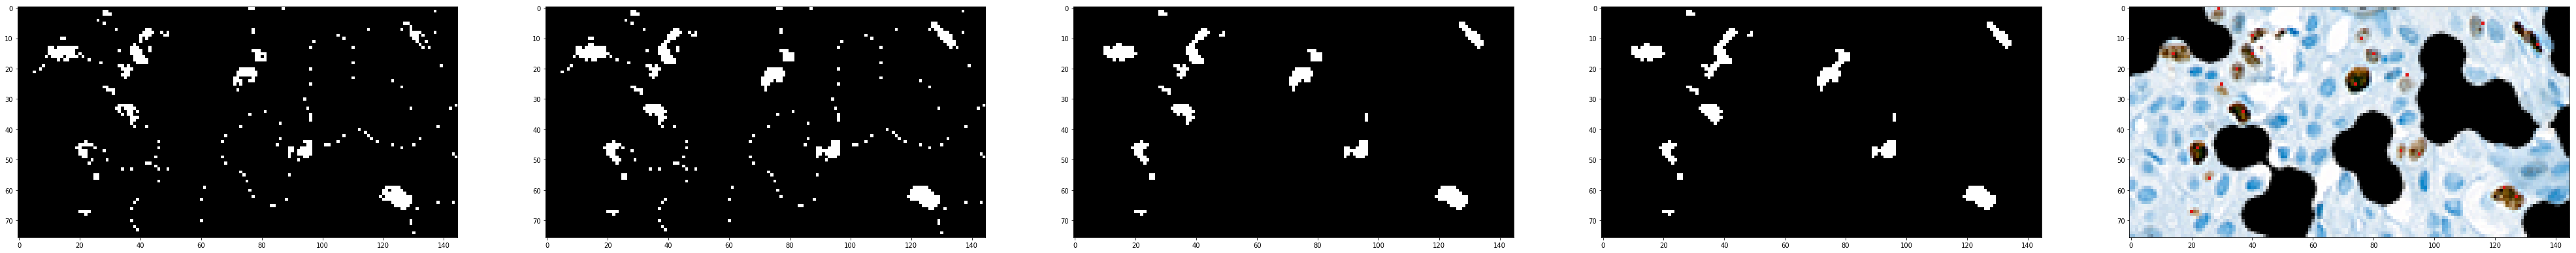

0.8

In [538]:
validateResults(settings.file_name, 405, 550, 68, 144, True)